# Lab:  Nonlinear Least Squares for Modeling Materials

Nonlinear least squares (NLLS) is a widely-used method for modeling data.  In NLLS, we wish to fit a model of the form,

     yhat = g(x,w)
     
where `w` is a vector of paramters and `x` is the vector of predictors.  We find `w` by minimizing a least-squares function 

     f(w) = \sum_i (y_i - g(x_i,w))^2
     
where the summation is over training samples `(x_i,y_i)`.  This is similar to linear least-squares, but the function `g(x,w)` may not be linear in `w`.  In general, this optimization has no closed-form expression.  So numerical optimization must be used.  

In this lab, we will implement gradient descent on NLLS in a problem of physical modeling of materials.  Specifically, we will estimate parameters for expansion of copper as a function of temperature using a real dataset.  In doing this lab, you will learn to:
* Set up a nonlinear least squares as an unconstrained optimization function
* Compute initial parameter estimates for a simple rational model
* Compute the gradients of the least squares objective
* Implement gradient descent for minimizing the objective
* Implement momentum gradient descent
* Visualize the convergence of the algorithm

We first import some key packages.

In [340]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

## Load the Data

The NIST agency has an excellent [nonlinear regression website](https://www.itl.nist.gov/div898/strd/nls/nls_main.shtml) that has several datasets for nonlinear regression problems.  In this lab, we will use the data from a NIST study involving the thermal expansion of copper. The response variable is the coefficient of thermal expansion, and the predictor variable is temperature in degrees kelvin.  

> Hahn, T., NIST (1979), Copper Thermal Expansion Study.  (unpublished}

You can download the data as follows.

In [341]:
url = 'https://itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Hahn1.dat'
df = pd.read_csv(url, skiprows=60, sep=' ',skipinitialspace=True, names=['x0','y0','dummy'])
df.head()

,x0,y0,dummy
0,0.591,24.41,NaN
1,1.547,34.82,NaN
2,2.902,44.09,NaN
3,2.894,45.07,NaN
4,4.703,54.98,NaN


Extract the `x0` and `y0` into arrays.  Rescale, `x0` and `y0` to values between `0` and `1` by dividing `x0` and `y0` by the maximum value.  Store the scaled values in vectors `x` and `y`.  The rescaling will help with the conditioning of the fitting.  Plot, `y` vs. `x`. 

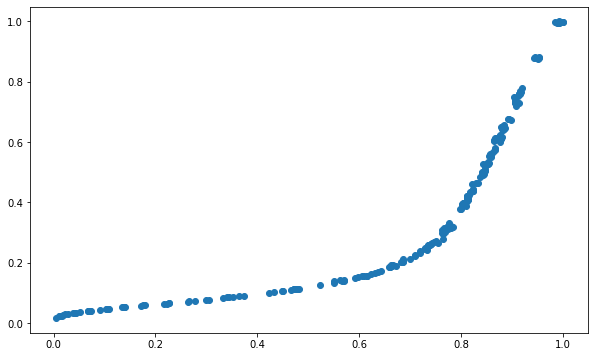

In [342]:
# TODO
x0 = np.array(df['x0'])
y0 = np.array(df['y0'])
x = x0/np.max(x0)
y = y0/np.max(y0)
plt.figure(figsize=(10,6))
plt.plot(x, y, 'o')

To make the problem a little more challenging, we will add some noise.  Add random Gaussian noise with mean 0 and std. dev = 0.02 to `y`.  Store the noisy results in `yn`. You can use the `np.random.normal()` function to add Gaussian noise. Plot `yn` vs. `x`.

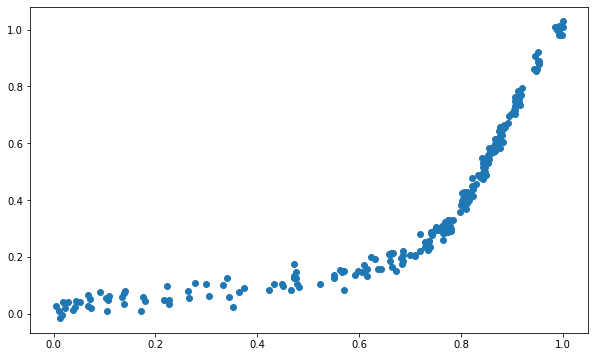

In [343]:
# TODO
yn = y + np.random.normal(0, 0.02, len(y))
plt.figure(figsize=(10,6))
plt.plot(x, yn, 'o')

Split the data `(x,yn)` into training and test.  Let `xtr,ytr` be training data and `xts,yts` be the test data.  You can use the `train_test_split` function.  Set `test_size=0.33` so that 1/3 of the samples are held out for test.

In [344]:
from sklearn.model_selection import train_test_split

# TODO
xtr, xts, ytr, yts = train_test_split(x, yn, test_size=0.33)

## Initial Fit for a Rational Model

The [NIST website](https://www.itl.nist.gov/div898/strd/nls/data/hahn1.shtml) suggests using a *rational* model of the form,

      yhat = (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
      
with `d=3`.  The model parameters are `w = [a[0],...,a[d],b[0],...,b[d-1]]` so there are `2d+1` parameters total.    Complete the function below that takes vectors `w` and `x` and predicts a set of values `yhat` using the above model.
   

In [345]:
def predict(w,x):
    
    # Get the length
    d = (len(w)-1)//2
    
    # TODO.  Extract a and b from w
    a = w[0:d+1]
    b = w[d+1:]
    
    # TODO.  Compute yhat.  You may use the np.polyval function
    # But, remember you must flip the order the a and b
    a_poly = np.polyval(a[::-1],x)
    b_poly = x * np.polyval(b[::-1],x) + 1
    yhat = a_poly / b_poly
    return yhat

When we fit with a nonlinear model, most methods only get convergence to a local minima.  So, you need a good initial condition.  For a rational model, one way to get is to realize that if:


    y ~= (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
    
Then:

    y ~= a[0] + a[1]*x + ... + a[d]*x^d - b[0]*x*y + ... - b[d-1]*x^d*y.
    
So, we can solve for the the parameters `w = [a,b]` from linear regression of the predictors,

    Z[i,:] = [ x[i], ... , x[i]**d, y[i]*x[i], ... , y[i}*x[i]**d ] 

In [346]:
d = 3

# TODO.  Create the transformed feature matrix
# Z = ...
pow_d = np.arange(1,d+1)
z1 = xtr[:,None] ** pow_d[None,:]
z2 = -ytr[:,None] * z1
z = np.hstack((z1,z2))

# TODO.  Fit with parameters with linear regression
regr = LinearRegression()
regr.fit(z, ytr)

# TODO
# Extract the parameters from regr.coef_ and regr.intercept_ and store the parameter vector in winit
w0 = regr.coef_
a0 = regr.intercept_
winit = np.hstack((a0,w0))

Now plot the predicted values of the `yhat` vs. `x` using your estimated parameter `winit` for 1000 values `x` in `[0,1]`.  On the same plot, plot `yts` vs. `xts`.  You will see that you get a horrible fit.

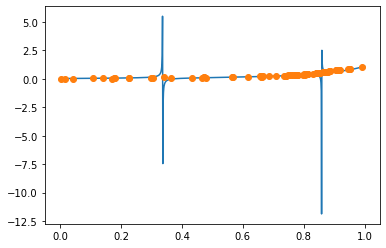

In [347]:
# TODO
xp = np.linspace(0,1,1000)
yhat = predict(winit, xp)
plt.plot(xp, yhat)
plt.plot(xts, yts, 'o')

The reason the previous fit is poor is that the denominator in `yhat` goes close to zero.   To avoid this problem, we can use Ridge regression, to try to keep the parameters close to zero.  Re-run the fit above with `Ridge` with `alpha = 1e-3`. You should see you get a reasonable, but not perfect fit.

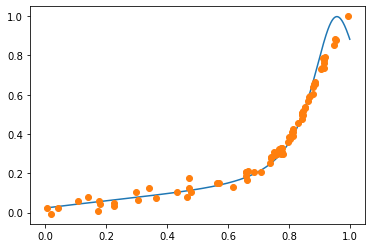

In [348]:
# TODO.  Fit with parameters with linear regression
regr = Ridge(alpha=1e-3)
regr.fit(z, ytr)

# TODO
# Extract the parameters from regr.coef_ and regr.intercept_
w0 = regr.coef_
a0 = regr.intercept_
winit = np.hstack((a0,w0))

# TODO
xp = np.linspace(0,1,1000)
yhat = predict(winit, xp)
plt.plot(xp, yhat)
plt.plot(xts, yts, 'o')

## Creating a Loss Function

We can now use gradient descent to improve our initial estimate.  Complete the following function to compute

    f(w) = 0.5*\sum_i (y[i] - yhat[i])^2
    
and `fgrad`, the gradient of `f(w)`.

In [349]:
x = np.array([1,2,3,4,5])
pow1 = np.arange(1,5)
pow2 = np.arange(0,5)

print( x[:,None] ** pow1[None,:] )

[[  1   1   1   1]
 [  2   4   8  16]
 [  3   9  27  81]
 [  4  16  64 256]
 [  5  25 125 625]]


In [350]:
def feval(w,x,y):
        
    
    # TODO.  Parse w

    # Get the length
    d = (len(w)-1)//2

    a = w[0:d+1]
    b = w[d+1:]
    
    # TODO.  Znum[i,j] = x[i]**j
    pow1 = np.arange(0,d+1)
    Znum = x[:,None] ** pow1[None,:]

    # TODO.  Zden[i,j] = x[i]**(j+1)
    pow2 = np.arange(1,d+1)
    Zden = x[:,None] ** pow2[None,:]
       
    # TODO.  Compute yhat 
    # Compute the numerator and denominator
    numerator = Znum @ a
    denominator = Zden @ b
    yhat = numerator / (1+denominator)
    
    # TODO.  Compute loss
    f = 0.5 * np.sum( (yhat-y) ** 2)
    
    # TODO.  Compute gradients
    e = yhat-y
    eden = e/(1+denominator)
    dJ_da = eden.dot(Znum)
    enum = -e*yhat/(1+denominator)
    dJ_db = enum.dot(Zden)
    fgrad = np.hstack((dJ_da, dJ_db))
    
    return f, fgrad


Test the gradient function:
* Take `w0=winit` and compute `f0,fgrad0 = feval(w0,xtr,ytr)`
* Take `w1` very close to `w0` and compute `f1,fgrad1 = feval(w1,xtr,ytr)`
* Verify that `f1-f0` is close to the predicted value based on the gradient.

In [351]:
# TODO
w0 = winit
p = len(winit)
w1 = w0 + 0.00001
f0, fgrad0 = feval(w0,xtr,ytr)
f1, fgrad1 = feval(w1,xtr,ytr)

print([f1-f0, fgrad0.dot(w1-w0)])

[0.0005973303695467613, 0.0005814553515394794]


## Implement gradient descent

We will now try to minimize the loss function with gradient descent.  Using the function `feval` defined above, implement gradient descent.  Run gradient descent with a step size of `alpha=1e-6` starting at `w=winit`.  Run it for `nit=10000` iterations.  Compute `fgd[it]`= the objective function on iteration `it`.  Plot `fgd[it]` vs. `it`.  

You should see that the training loss decreases, but it still hasn't converged after 10000 iterations.

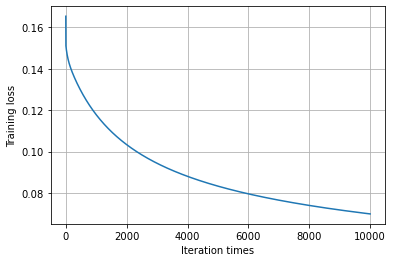

In [352]:
# TODO
# fgd = ...
nit = 10000
step = 1e-6
wt = winit
fgd = np.zeros(nit)

for i in range(nit):
    ft, fgradt = feval(wt, xtr, ytr)
    fgd[i] = ft
    wt = wt - step * fgradt

plt.plot(fgd)
plt.xlabel('Iteration times')
plt.ylabel('Fixed Training loss')
plt.grid()

Now, try to get a faster convergence with adaptive step-size using the Armijo rule. Implement the gradient descent with adaptive step size.  Let `fadapt[it]` be the loss function on iteration `it`.  Plot `fadapt[it]` and `fgd[it]` vs. `it` on the same graph.  You should see a slight improvement, but not much.

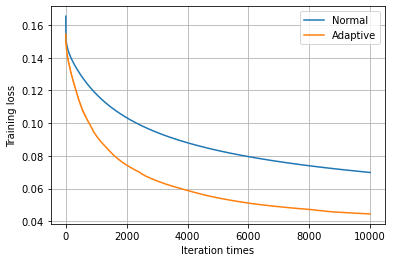

In [353]:
# TODO
# fadapt = ...
nit = 10000
step = 1e-6  # Initial step
wt0 = winit
fadapt = np.zeros(nit)
f0 , fgrad0 = feval(wt0, xtr, ytr)

for i in range(nit):

    wt1 = wt0 - step * fgrad0
    f1, fgrad1 = feval(wt1, xtr, ytr)

    c = 0.5
    beta = 1.5
    
    #If Armijo rule passes:
    if ( (f0 - f1) >= c * fgrad0 @ (wt0 - wt1) ) and (f1 < f0):
        step = step * beta

        # prepare for the next iteration
        f0 = f1
        fgrad0 = fgrad1
        wt0 = wt1
    else:
        step = step / beta
        # Reject point, so do nothing

    # Record this step
    fadapt[i] = f0


plt.plot(fgd)
plt.plot(fadapt)
plt.xlabel('Iteration times')
plt.ylabel('Training loss')
plt.legend(['Fixed', 'Adaptive'])
plt.grid()

Using he final estimate for `w` from the adaptive step-size plot the predicted values of the `yhat` vs. `x` usfor 1000 values `x` in `[0,1]`.  On the same plot, plot `yhat` vs. `x` for the initial parameter `w=winit`.  Also, plot `yts` vs. `xts`.  You should see that gradient descent was able to improve the estimat slightly, although the initial estimate was not too bad.

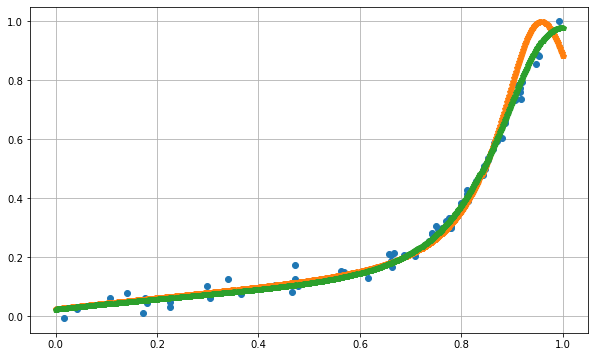

In [371]:
# TODO
xp = np.linspace(0,1,500)
yinit = predict(winit, xp)
yhat = predict(wt0, xp)
plt.figure(figsize=(10,6))
plt.plot(xts, yts,'o')
plt.plot(xp, yinit,'p')
plt.plot(xp, yhat,'p')
plt.grid()

## Momentum Gradient Descent

This section is bonus.

One way to improve gradient descent is to use *momentum*.  In momentum gradient descent, the update rule is:

    f, fgrad = feval(w,...)
    z = beta*z + fgrad
    w = w - step*z
    
This is similar to gradient descent, except that there is a second order term on the gradient.  Implement this algorithm with `beta = 0.99` and `step=1e-3`.   Compare the convergence of the loss function with gradient descent.  

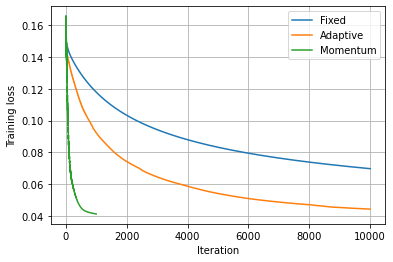

In [370]:
# TODO
nit = 1000
step = 1e-6
beta = 0.99
wt = winit
p = len(winit)
z = np.zeros(p)
fMG = np.zeros(nit)
for i in range(nit):
    ft, fgradt = feval(wt, xtr, ytr)
    z = beta*z + fgradt
    wt = wt - step * z
    fMG[i] = ft

plt.plot(fgd)
plt.plot(fadapt)
plt.plot(fMG)
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.legend(['Fixed', 'Adaptive', 'Momentum'])
plt.grid()

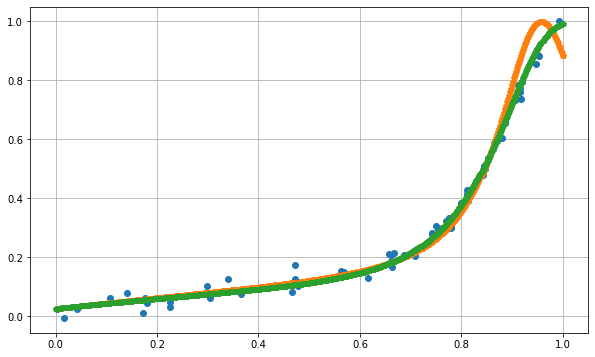

In [372]:
# TODO
# plot yhat vs. x
xp = np.linspace(0,1,500)
yinit = predict(winit, xp)
yhat = predict(wt, xp)
plt.figure(figsize=(10,6))
plt.plot(xts, yts,'o')
plt.plot(xp, yinit,'p')
plt.plot(xp, yhat,'p')
plt.grid()

## Beyond This Lab
In this lab, we have just touched at some of the ideas in optimization.  There are several other important algorithms that you can explore:
* [Levenberg-Marquardt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) method for non-linear least squares
* Newton's method
* More difficult non-linear least squares problems.